# Cruce de datos - Los Maitenes

In [25]:
%load_ext autoreload
%autoreload 2

import sys
import os
from functools import reduce
import copy
from collections import OrderedDict
import datetime

project_path = os.path.abspath('../')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
from scipy.stats import circmean

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data
from src.eda.processing import *
from src.eda.visualization import plot_temp, conf_matrix
import dataframe_image as dfi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Carga de datos 

### Variables y ventana de análisis

In [26]:
params = ['SO2','NO2', 'NO', 'NOX', 'O3', 'CO']
from_last = '5y'

### Datos

In [27]:
data_df = get_minma_data(params, 'maitenes', from_last=from_last)
data_df = data_df.filter(regex=("Registros no validados_"))
data_df.columns = data_df.columns.str.strip('Registros no validados_')

meteo_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'Torre Meteo Codelco Ventanas.xlsx').set_index('date')
meteo_df['T_diff'] = 100*(meteo_df['T_40'] - meteo_df['T_10']) / 30

cems_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'CEMS industrial datos Quintero.xlsx', index_col=0, skiprows=2)

/home/agonzalez/projects/mds7201-minma-so2/src/data/make_dataset.py:62: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  from_date = to_date - pd.Timedelta(from_last)


### Merge de datos

In [28]:
data_df = pd.merge(meteo_df, data_df, left_index=True, right_index=True)
# [['T_diff', 'T_20', 'HR_20', 'P_20', 'WS_20', 'WD_20']]
# data_df = pd.merge(nefo_df, data_df, left_index=True, right_index=True)
data_df = pd.merge(cems_df, data_df, left_index=True, right_index=True)
data_df.head()

,CEMS U1 Ventanas,CEMS U2 Ventanas,CEMS U3 Ventanas,CEMS U4 Ventanas,CEMS Chimenea Codelco,CEMS Planta Acido Codelco,T_10,T_20,T_40,WD_10,...,HR_20,HR_40,P_20,T_diff,SO2,NO2,NO,NOX,O3,CO
2019-08-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,9.32983,10.09780,9.07899,194.392,...,59.6488,60.0490,1020.00,-0.836133,0.81,2.78,1.25253,3.84010,24.0,0.10
2019-08-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,8.65620,9.47633,8.43515,154.067,...,62.3453,62.6893,1020.02,-0.736833,0.88,2.86,1.09161,3.78583,22.0,0.10
2019-08-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,8.06523,8.97534,7.88302,134.585,...,64.6565,65.0258,1020.00,-0.607367,0.80,2.48,1.28838,3.76687,23.0,0.11
2019-08-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7.95675,8.67967,7.68432,184.304,...,65.4817,65.6469,1020.00,-0.908100,0.74,2.66,1.26971,3.87118,22.0,0.11
2019-08-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7.95688,8.86282,7.96602,171.480,...,63.6508,63.1445,1020.00,0.030467,0.88,2.87,1.38953,4.25663,21.0,0.11


## División por días de peaks

In [29]:
# Separación de días normales y peaks
_, peak_days = get_SO2_peaks(data_df, 'SO2', 130)
_, limit_days = get_SO2_limit(data_df, 'SO2', 130)

# Filtro de dataframe según el tipo de día
data_peaks_df = filter_by_dates(data_df, peak_days)
data_limit50_df = filter_by_dates(data_df, limit_days)

## Distribución acumulada de distintas métricas

/home/agonzalez/projects/mds7201-minma-so2/src/eda/visualization.py:216: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


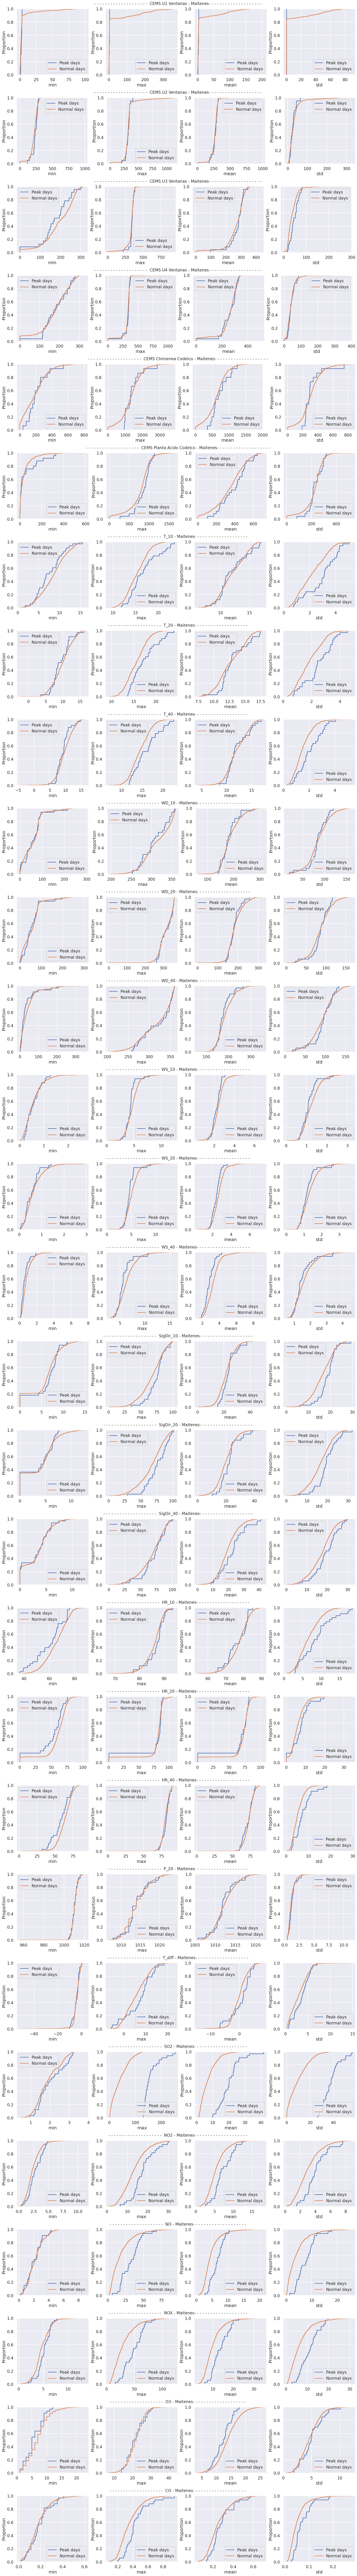

In [30]:
plot_temp([data_peaks_df, data_limit50_df], 'Maitenes', type='cumdistr')

## Matriz de confusion

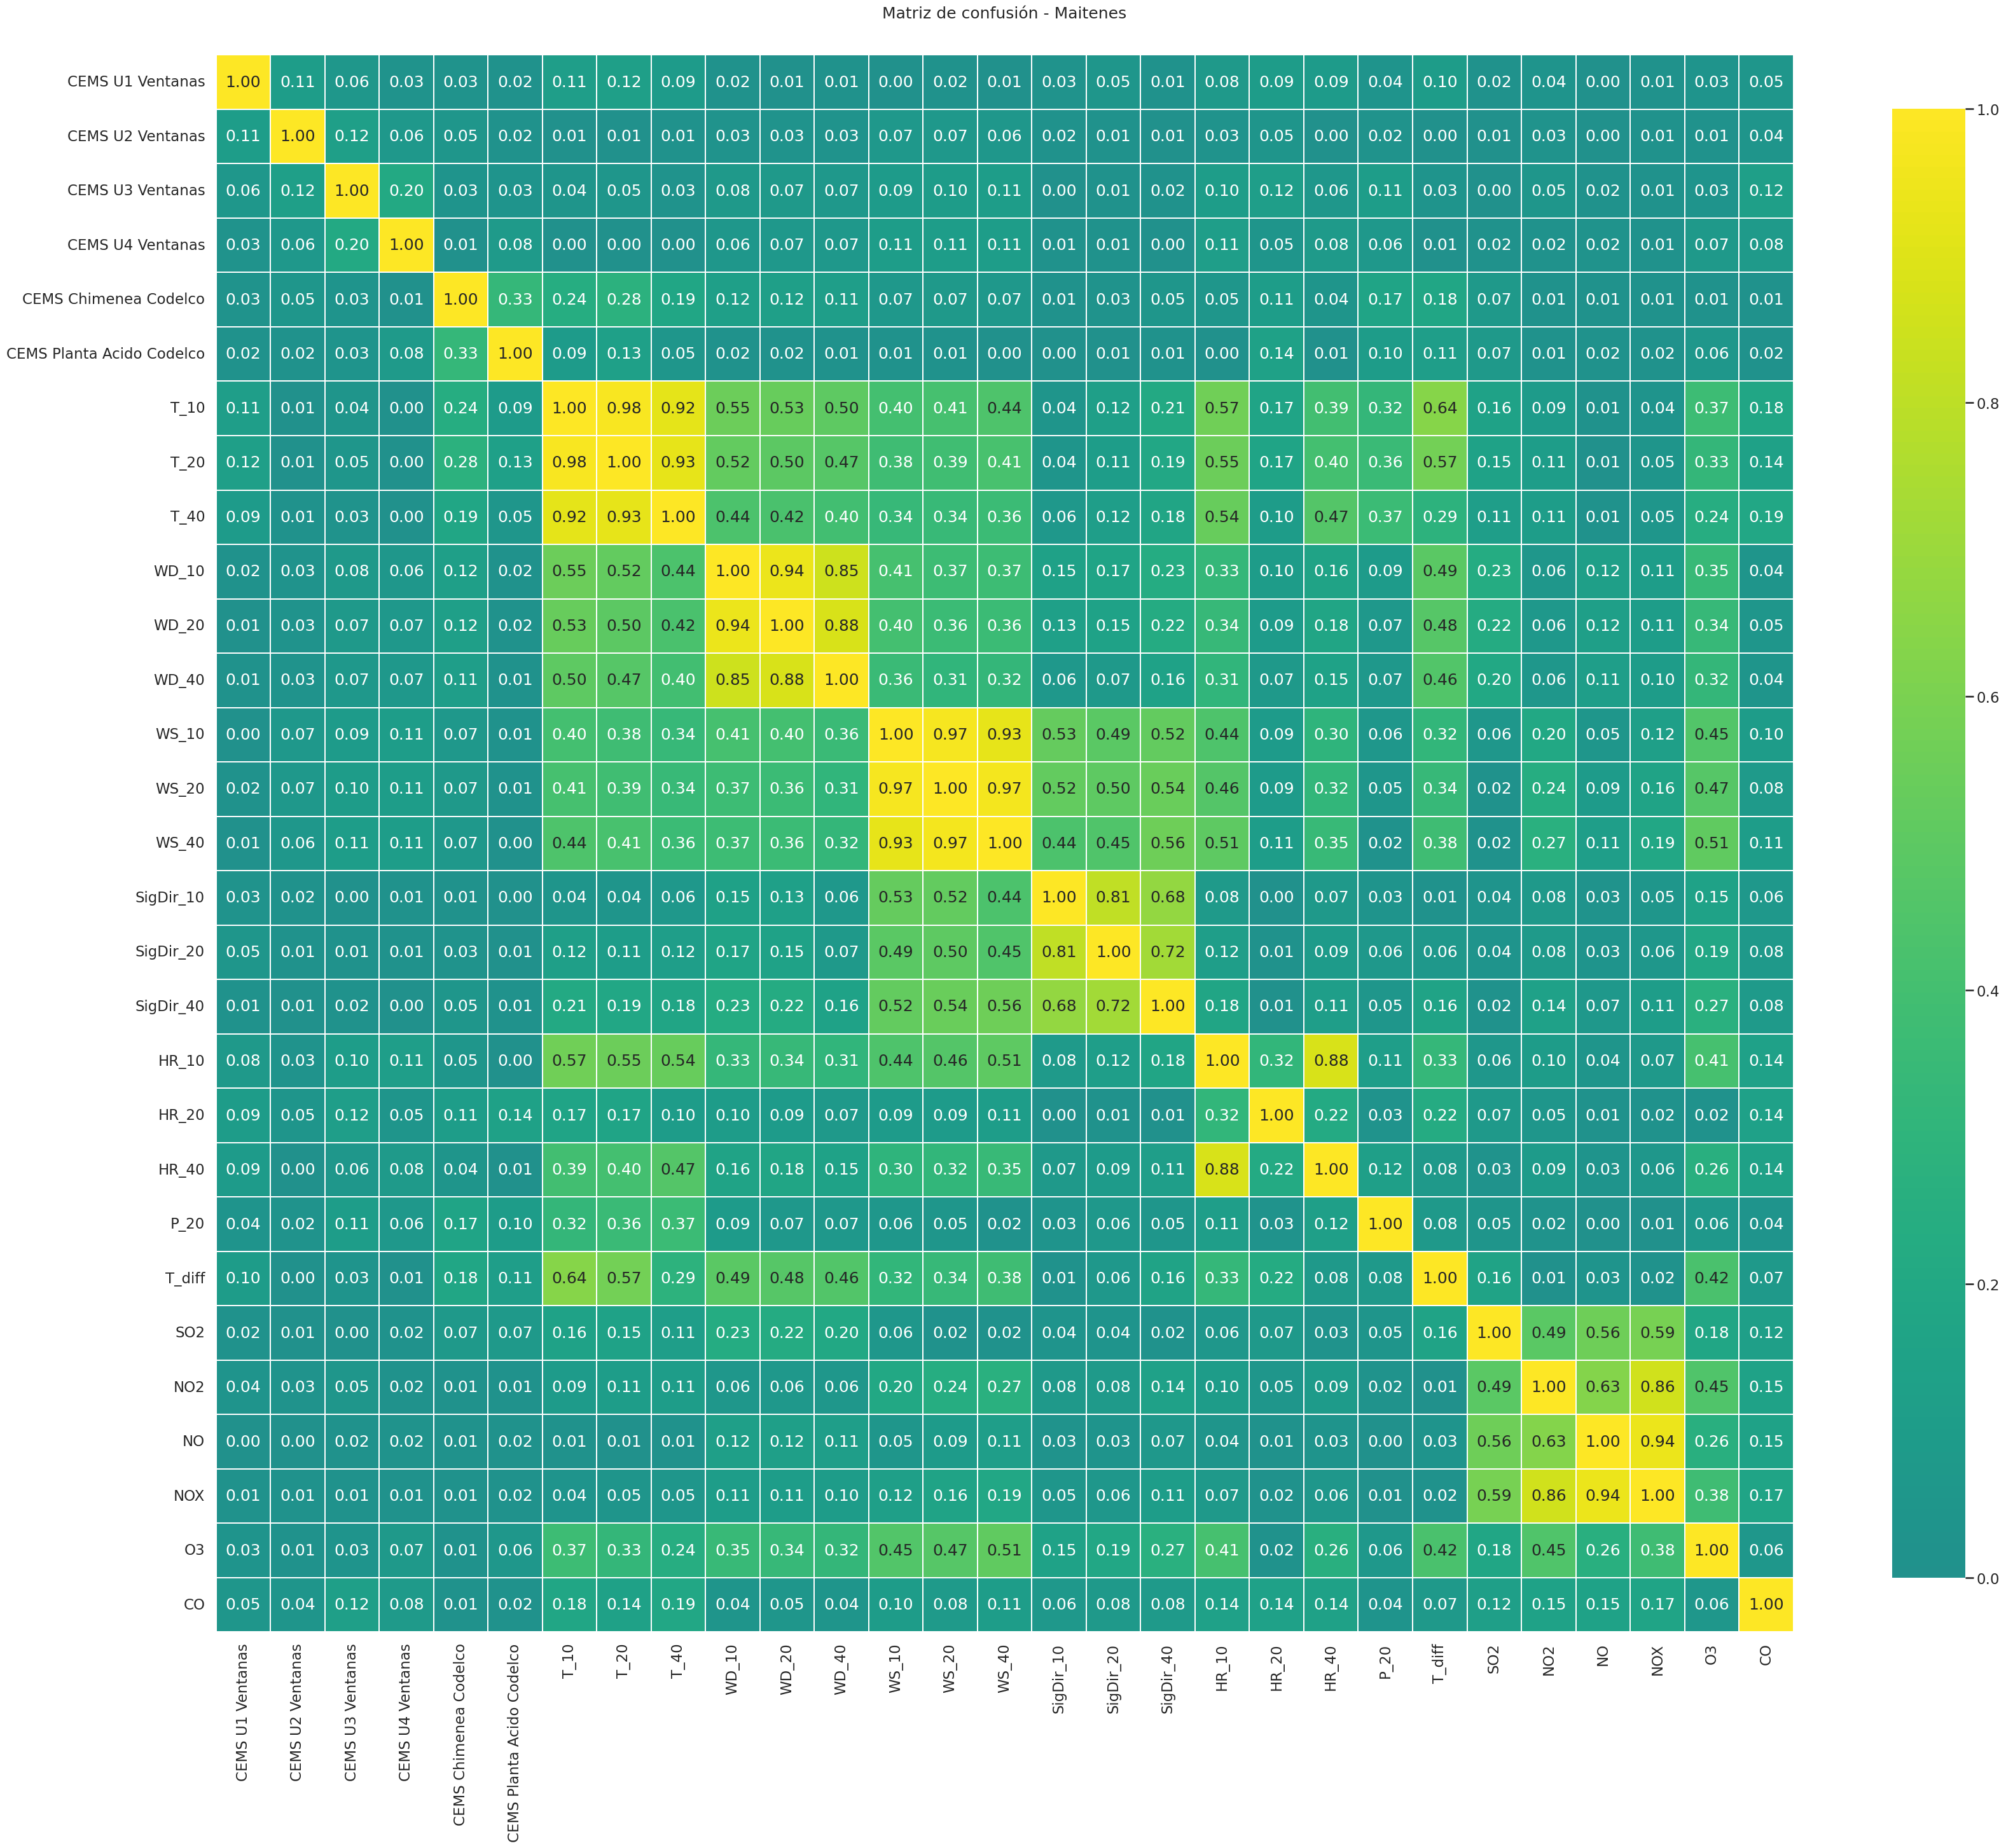

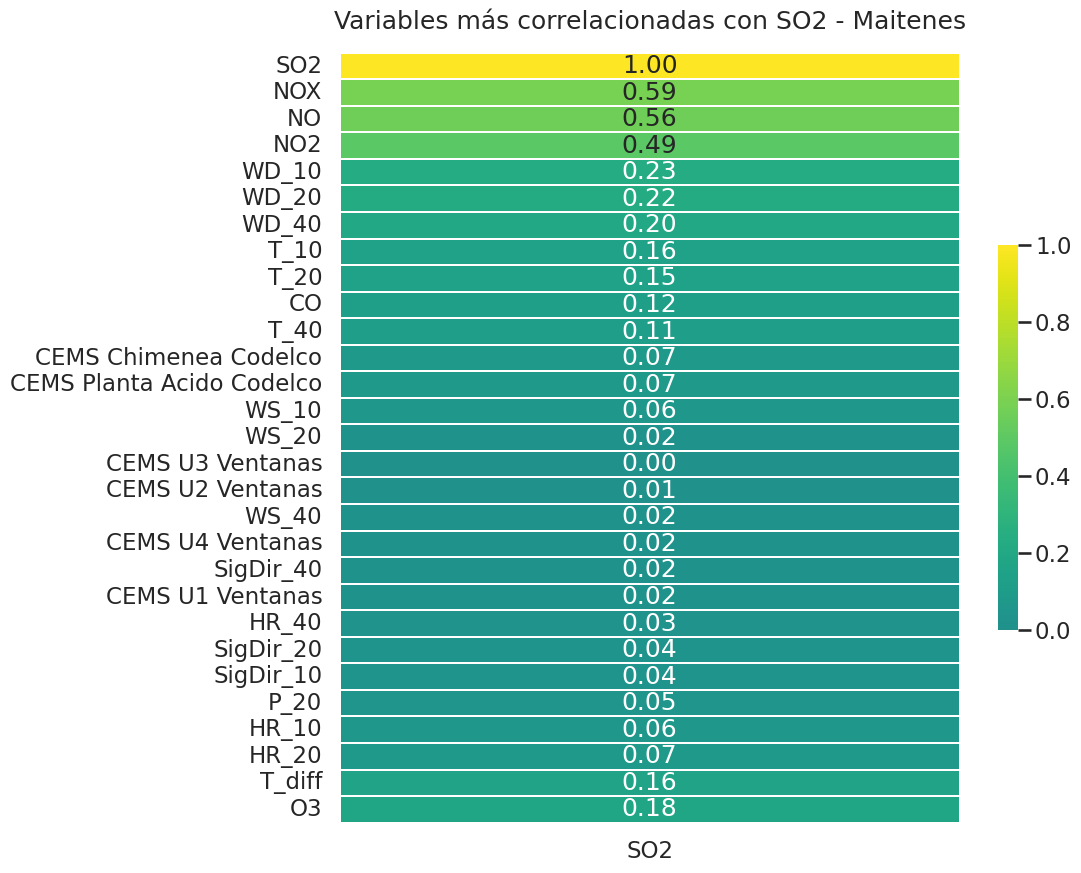

In [31]:
fig, ax = plt.subplots(figsize=(40,60))
conf_matrix(data_df, ax=ax)
ax.set_title('Matriz de confusión - Maitenes', y=1.02)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
conf_matrix(data_df, SO2_only=True, ax=ax)
ax.set_title('Variables más correlacionadas con SO2 - Maitenes', y=1.02)
plt.show()